# 1) Import libraries

In [1]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo

# 2) Initialize Parameters

In [2]:
excess_electricity_cost = 100        # penalty for generating electricity more than needed
hourly_excess_ele_ub    = 1000       # max amount of excess electricity in one hour
total_excess_ele_ub     = 10000      # max amount of excess electricity in the horizon

curtailment_cost        = 30         # penalty for generating electricity less than needed
hourly_curtailed_ele_ub = 1000       # max amount of electricity shortage in one hour
total_curtailed_ele_ub  = 10000      # max amount of electricity shortage in the horizon

# 2) Read data

## 2-1) Generators' data

In [3]:
GenData = pd.read_excel("GenData.xlsx", header = 0, index_col = 0)
G = list(GenData.index) # will be used as the set of generators in the optimization model
NumGen = len(G)
GenData

,MinOnTime,MinOffTime,RampUp,RampDown,pmin,pmax,smax,StartUpCost,ShutDownCost,a,b,c
1,2,2,30,15,20,90,15,500,500,0.010,12.888,6.78
2,1,2,15,15,10,50,10,500,500,0.015,12.888,6.78
3,2,2,60,60,20,90,15,800,800,0.012,26.244,31.67
4,2,1,15,15,15,60,10,300,300,0.020,17.820,10.15


## 2-2) Demand Data

<AxesSubplot:>

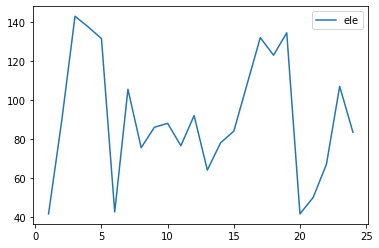

In [4]:
load = pd.read_excel("load.xlsx", header = 0, index_col = 0)
T = list(load.index) # will be used as the set of time in the optimization model
Horizon = len(T)
load.plot()

# 4) Linearization

In [5]:
cost_coef = [list(GenData.loc[:,"c"]),
             list(GenData.loc[:,"b"]),
             list(GenData.loc[:,"a"])]

pmin = np.array(GenData.loc[:,"pmin"])
pmax = np.array(GenData.loc[:,"pmax"])

def GenCost(cost_coef,P):
    return cost_coef[2]*np.power(P, 2) + cost_coef[1]*np.power(P, 1) + cost_coef[0]

lines_num = 10                                 # how many lines you want to fit on the quadratic cost function
points_num = lines_num + 1
points = np.linspace(pmin,pmax,num=points_num)
costs = GenCost(cost_coef,points).T
points = points.T

slope = np.zeros((NumGen, lines_num))          # slope of each fitted line
for i in range(NumGen):
    for j in range(lines_num):
        slope[i,j] = (costs[i,j+1] - costs[i,j]) / (points[i,j+1] - points[i,j])

linear_range = []                              # distance between two consecutive points (beginning and end of each line)
for i in range(NumGen):
    linear_range.append(points[i,1] - points[i,0])

linear_range = pd.DataFrame(linear_range, columns = ['linear_range'], index = G)
slope = pd.DataFrame(slope, columns = list(range(1,lines_num +1)), index = G)

# 5) Initialize the model

In [6]:
model = pyo.ConcreteModel(name="Unit Commitment")

# 6) Define sets

In [7]:
# G defined above (when reading generators' data)
# T defined above (when reading demand data)
L = list(range(1,lines_num +1))

# 7) Define variables

In [8]:
model.pl = pyo.Var(G,T,L, within=pyo.NonNegativeReals) # power at each time step for each linear part and generator
model.p  = pyo.Var(G,T,   within=pyo.NonNegativeReals, initialize = 0) # power at each time step for each generator

model.EE = pyo.Var(T,     within=pyo.NonNegativeReals) # Excess electricity at each time
model.CE = pyo.Var(T,     within=pyo.NonNegativeReals) # curtailed electricity at each time

model.v  = pyo.Var(G,T,   within=pyo.Binary, initialize = 0)           # turn gen g on at time t
model.w  = pyo.Var(G,T,   within=pyo.Binary, initialize = 0)           # turn gen g off at time t
model.u  = pyo.Var(G,T,   within=pyo.Binary, initialize = 0)           # whether gen g is working or not

# 8) Objective function

In [9]:
def obj_rule(model):
    # start up and shut down costs
    SUSDC = sum( GenData.loc[g,'StartUpCost']*model.v[g,t] + GenData.loc[g,'ShutDownCost']*model.w[g,t] for g in G for t in T )
    
    # operational costs
    OC    = sum( slope.loc[g,l]*model.pl[g,t,l] for g in G for t in T for l in L)
    
    # excess electricity cost
    EEC   = excess_electricity_cost*sum( model.EE[t] for t in T )
    
    # electricity shortage cost
    CEC   = curtailment_cost*sum( model.CE[t] for t in T)
    
    return SUSDC + OC + EEC + CEC

model.obj = pyo.Objective(rule=obj_rule, sense = pyo.minimize)

# 9) Constraints

## 9-1) Unit commitment constraints

### 9-1-1) Start up & Shut down

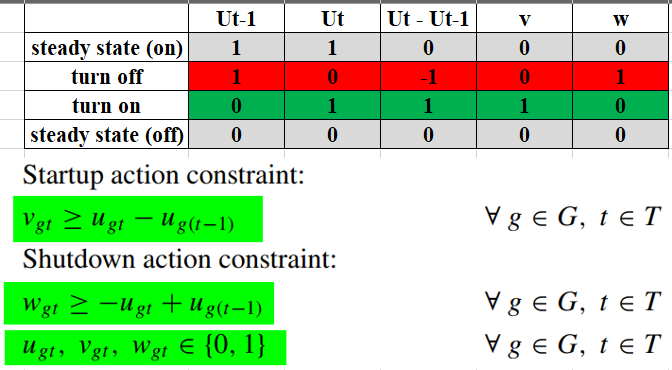

In [10]:
def SU_rule(model,g,t):
    if t > 1:
        return model.u[g,t] - model.u[g,t-1] <= model.v[g,t]
    else:
        return model.u[g,t] <= model.v[g,t]
model.SU = pyo.Constraint(G,T, rule = SU_rule)

def SD_rule(model,g,t):
    if t > 1:
        return model.u[g,t-1] - model.u[g,t] <= model.w[g,t]
    else:
        return pyo.Constraint.Skip  # since we initialized with zero, we can not shut down at the beginning as there is nothing to shut it down
model.SD = pyo.Constraint(G,T, rule = SD_rule)

### 9-1-2) Min up time & Min down time

In [11]:
def min_up_time_rule(model,g,t):
    alpha = min(Horizon,t+GenData.loc[g,'MinOnTime']-1)
    K = list(range(t,alpha +1))
    return sum( model.u[g,k] for k in K ) >= len(K)*model.v[g,t]
model.MUT = pyo.Constraint(G,T, rule = min_up_time_rule)

def min_down_time_rule(model,g,t):
    alpha = min(Horizon,t+GenData.loc[g,'MinOffTime']-1)
    K = list(range(t,alpha +1))
    return sum( 1-model.u[g,k] for k in K ) >= len(K)*model.w[g,t]
model.MDT = pyo.Constraint(G,T, rule = min_down_time_rule)

## 10) Thermal Generation constraints

### 10-1) Lower and upper bounds of thermal power generation

In [12]:
def power_ub_rule(model,g,t):
    return model.p[g,t] <= model.u[g,t]*GenData.loc[g,'pmax']
model.power_ub = pyo.Constraint(G,T, rule = power_ub_rule)

def power_lb_rule(model,g,t):
    return model.u[g,t]*GenData.loc[g,'pmin'] <= model.p[g,t]
model.power_lb = pyo.Constraint(G,T, rule = power_lb_rule)

### 10-2) Ramp up & Ramp down

In [13]:
def RU_rule(model,g,t):
    if t > 1:
        return model.p[g,t] - model.p[g,t-1] <= GenData.loc[g,'RampUp']*(1+model.u[g,t-1]-model.u[g,t]) + GenData.loc[g,'pmin']*(2-model.u[g,t]-model.u[g,t-1])
    else:
        return model.p[g,t] == model.u[g,t]*GenData.loc[g,'pmin'] #pyo.Constraint.Skip
model.RU = pyo.Constraint(G,T, rule = RU_rule)

def RD_rule(model,g,t):
    if t > 1:
        return model.p[g,t-1] - model.p[g,t] <= GenData.loc[g,'RampDown']*(1-model.u[g,t-1]+model.u[g,t]) + GenData.loc[g,'pmin']*(2-model.u[g,t]-model.u[g,t-1])
    else:
        return pyo.Constraint.Skip
model.RD = pyo.Constraint(G,T, rule = RD_rule)

### 10-3) Excess electricity limit & Curtailment limit

In [14]:
####### hourly upper bound

def hourly_excess_ele_ub_rule(model,t):
    return model.EE[t] <= hourly_excess_ele_ub
model.hourly_excess_ele_ub = pyo.Constraint(T, rule = hourly_excess_ele_ub_rule)

def hourly_curtailed_ele_ub_rule(model,t):
    return model.CE[t] <= hourly_curtailed_ele_ub
model.hourly_curtailed_ele_ub = pyo.Constraint(T, rule = hourly_curtailed_ele_ub_rule)

####### total ub

def total_excess_ele_ub_rule(model):
    return sum( model.EE[t] for t in T ) <= total_excess_ele_ub
model.total_excess_ele_ub = pyo.Constraint(rule = total_excess_ele_ub_rule)

def total_curtailed_ele_ub_rule(model):
    return sum( model.CE[t] for t in T ) <= total_curtailed_ele_ub
model.total_curtailed_ele_ub = pyo.Constraint(rule = total_curtailed_ele_ub_rule)

### 10-4) Balance (Demand satisfaction)

In [15]:
def demand_rule(model,t):
    return sum(model.p[g,t] for g in G) - load.loc[t,'ele'] == model.EE[t] - model.CE[t]
model.demand = pyo.Constraint(T, rule = demand_rule)

### 10-5) Sum of piece wise powers

In [16]:
def linear_power_rule(model,g,t):
    return model.p[g,t] == sum( model.pl[g,t,l] for l in L )
model.linear_power = pyo.Constraint(G,T, rule = linear_power_rule)

# each P_L must be less than linear range
def linear_power_ub_rule(model,g,t,l):
    return model.pl[g,t,l] <= linear_range.loc[g,'linear_range']
model.linear_power_ub = pyo.Constraint(G,T,L, rule = linear_power_ub_rule)

In [17]:
status = pyo.SolverFactory("glpk").solve(model)

pyo.assert_optimal_termination(status)
print(pyo.check_optimal_termination(status))

True


In [ ]:
model.pprint()

In [18]:
model.p.pprint()

p : Size=96, Index=p_index
    Key     : Lower : Value : Upper : Fixed : Stale : Domain
     (1, 1) :     0 :  20.0 :  None : False : False : NonNegativeReals
     (1, 2) :     0 :  49.5 :  None : False : False : NonNegativeReals
     (1, 3) :     0 :  70.0 :  None : False : False : NonNegativeReals
     (1, 4) :     0 :  62.5 :  None : False : False : NonNegativeReals
     (1, 5) :     0 :  47.5 :  None : False : False : NonNegativeReals
     (1, 6) :     0 :  32.5 :  None : False : False : NonNegativeReals
     (1, 7) :     0 :  62.5 :  None : False : False : NonNegativeReals
     (1, 8) :     0 :  47.5 :  None : False : False : NonNegativeReals
     (1, 9) :     0 :  49.0 :  None : False : False : NonNegativeReals
    (1, 10) :     0 :  49.0 :  None : False : False : NonNegativeReals
    (1, 11) :     0 :  44.5 :  None : False : False : NonNegativeReals
    (1, 12) :     0 :  52.0 :  None : False : False : NonNegativeReals
    (1, 13) :     0 :  37.0 :  None : False : False : NonNeg

In [ ]:
power_data = {(g, t): pyo.value(model.p[g,t]) for g in G for t in T}
power_data = pd.DataFrame.from_dict(power_data, orient='index')
power_data
power_data.to_excel("C:/Users/ASUS/Desktop/ED_pyomo/res.xlsx")

## 11) Transmission constraints

## 12) Emission constraints